In [1]:
import os, random, numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Reproducibility
# -------------------------
SEED = 32
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Loading and Preparing the Dataset
Load the Fashion-MNIST dataset and prepare it for training

In [2]:

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape,  y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


# Data Preprocessing
Normalize the data and create validation split

In [3]:

# scale to [0,1] and add channel dimension
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]  # (N, 28, 28, 1)
x_test  = (x_test.astype("float32") / 255.0)[..., np.newaxis]

# Create validation split from training set (no test leakage)
X_train, X_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

print("Train/Val shapes:", X_train.shape, X_val.shape)

Train/Val shapes: (54000, 28, 28, 1) (6000, 28, 28, 1)


# Data Augmentation
Set up data augmentation pipeline for training

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
], name="augmentation")

# Model Architecture
Define the CNN model architecture with convolutional blocks

In [ ]:
# Define convolution block
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    return x

# Build the model
inputs = layers.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs, name="FashionMNIST_CNN")
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)
model.summary()

Model: "FashionMNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 157,610 (615.66 KB)

 Trainable params: 156,970 (613.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# ...existing code for model.fit...
# history = model.fit(
#     X_train, y_train_split,
#     validation_data=(X_val, y_val),
#     epochs=40,
#     batch_size=128,
#     callbacks=[early_stop, reduce_lr, model_checkpoint],
#     verbose=2
# )

# Model Training
Train the model with early stopping and learning rate reduction

In [6]:
# Set up callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=6, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train_split,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/40
422/422 - 199s - 471ms/step - accuracy: 0.6614 - loss: 0.9140 - val_accuracy: 0.2300 - val_loss: 4.0903 - learning_rate: 1.0000e-03
Epoch 2/40
422/422 - 185s - 439ms/step - accuracy: 0.7788 - loss: 0.6074 - val_accuracy: 0.7763 - val_loss: 0.6917 - learning_rate: 1.0000e-03
Epoch 3/40
422/422 - 205s - 487ms/step - accuracy: 0.8075 - loss: 0.5303 - val_accuracy: 0.8407 - val_loss: 0.4257 - learning_rate: 1.0000e-03
Epoch 4/40
422/422 - 199s - 471ms/step - accuracy: 0.8242 - loss: 0.4937 - val_accuracy: 0.7968 - val_loss: 0.5472 - learning_rate: 1.0000e-03
Epoch 5/40
422/422 - 188s - 447ms/step - accuracy: 0.8354 - loss: 0.4611 - val_accuracy: 0.8728 - val_loss: 0.3677 - learning_rate: 1.0000e-03
Epoch 6/40
422/422 - 195s - 461ms/step - accuracy: 0.8438 - loss: 0.4386 - val_accuracy: 0.8605 - val_loss: 0.3852 - learning_rate: 1.0000e-03
Epoch 7/40
422/422 - 177s - 420ms/step - accuracy: 0.8505 - loss: 0.4197 - val_accuracy: 0.8647 - val_loss: 0.3609 - learning_rate: 1.0000e-03

# Model Evaluation
Evaluate model performance on test set


Test accuracy: 0.9094 | Test loss: 0.2565


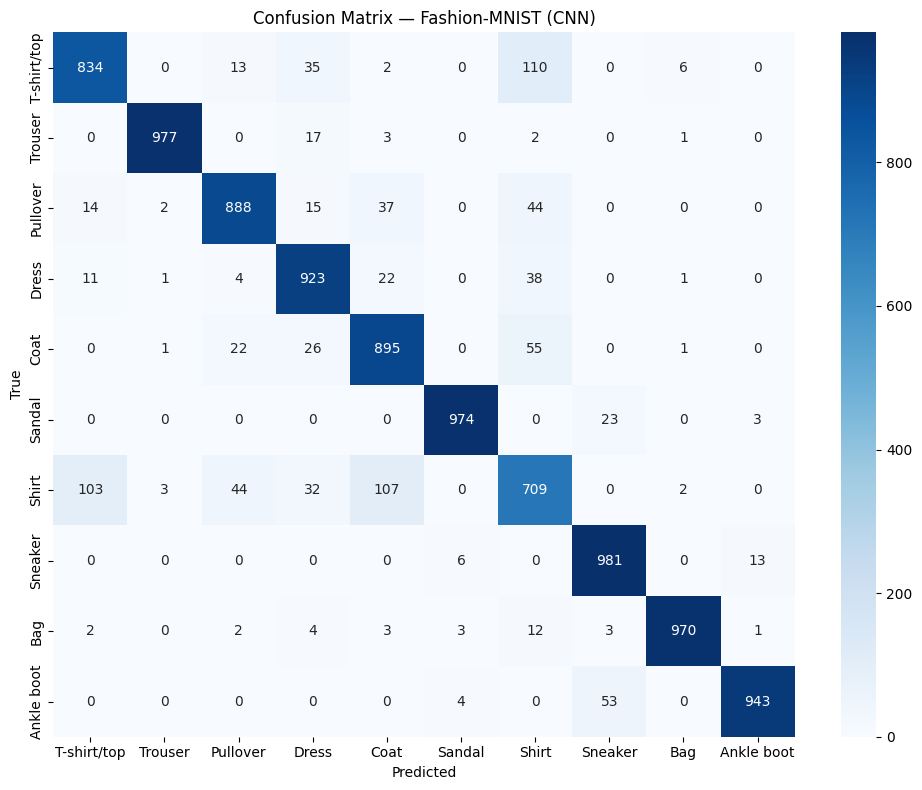


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8651    0.8340    0.8493      1000
     Trouser     0.9929    0.9770    0.9849      1000
    Pullover     0.9126    0.8880    0.9002      1000
       Dress     0.8774    0.9230    0.8996      1000
        Coat     0.8372    0.8950    0.8652      1000
      Sandal     0.9868    0.9740    0.9804      1000
       Shirt     0.7309    0.7090    0.7198      1000
     Sneaker     0.9255    0.9810    0.9524      1000
         Bag     0.9888    0.9700    0.9793      1000
  Ankle boot     0.9823    0.9430    0.9622      1000

    accuracy                         0.9094     10000
   macro avg     0.9100    0.9094    0.9093     10000
weighted avg     0.9100    0.9094    0.9093     10000



In [7]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Get predictions
predictions = model.predict(x_test, verbose=0)
y_pred = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Fashion-MNIST (CNN)')
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("\nClassification Report:")
print(report)

# Training History Visualization
Plot training and validation metrics

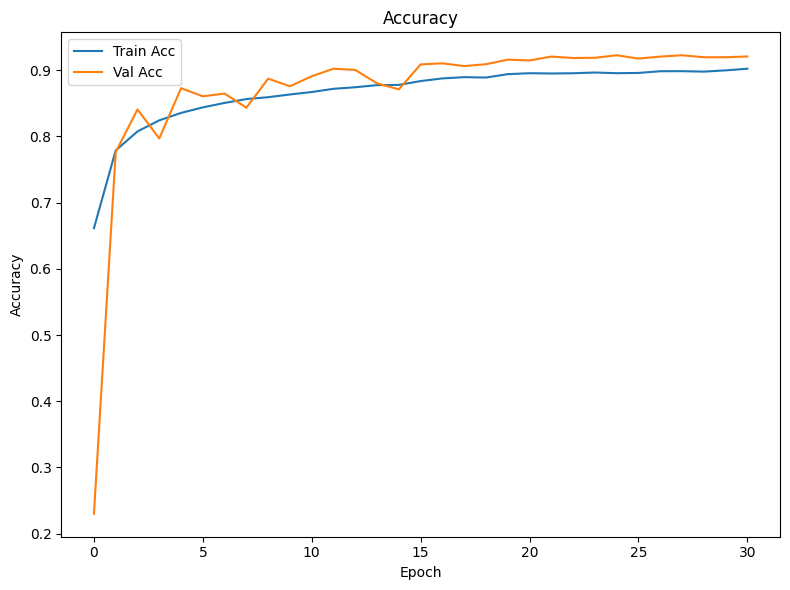

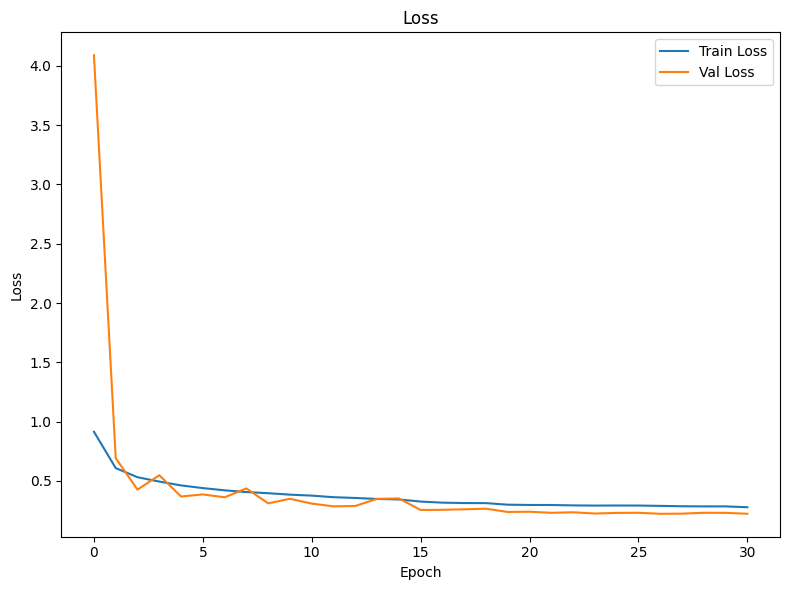

In [8]:
# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Misclassification Analysis
Display examples of misclassified images

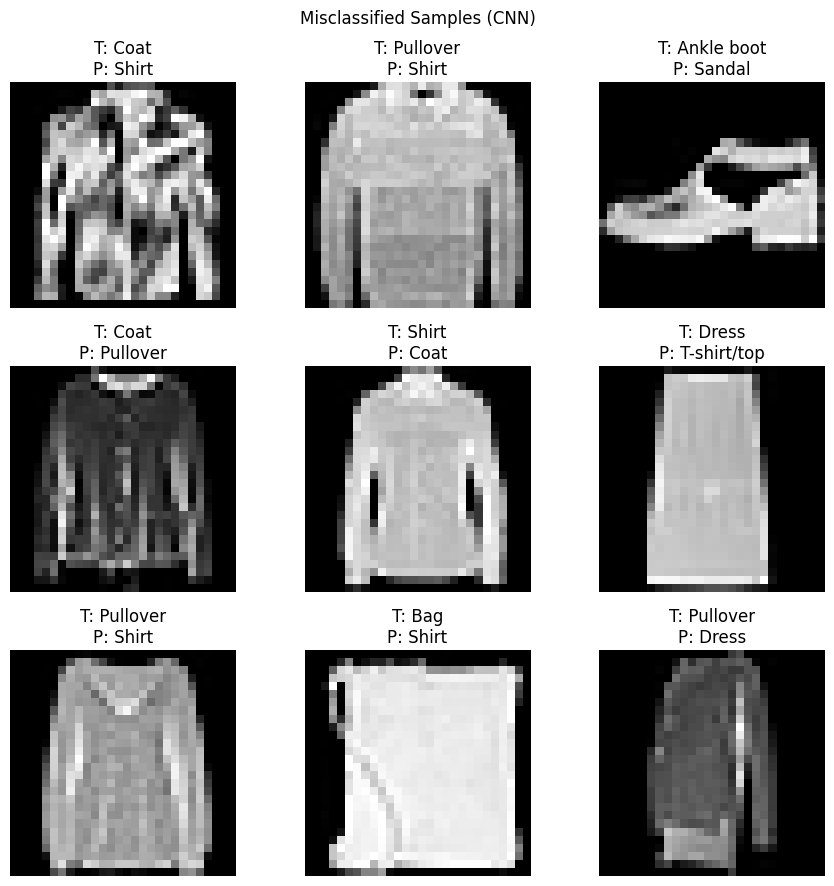

In [9]:
# Display misclassified examples
mis_idx = np.where(y_pred != y_test)[0][:9]
if mis_idx.size > 0:
    plt.figure(figsize=(9, 9))
    for i, idx in enumerate(mis_idx):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray')
        plt.title(f"T: {class_names[y_test[idx]]}\nP: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle('Misclassified Samples (CNN)')
    plt.tight_layout()
    plt.show()